### 【問題1】全結合層のクラス化
### 【問題2】初期化方法のクラス化

In [252]:
import numpy as np

class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.A = None
        self.Z = None
        self.hW = 0
        self.hB = 0

    def forward(self, X):
        self.Z = X  # backwardで前回のz = 今回の入力値を使うため
        self.A = X @ self.W + self.B
        # display("X")
        # display(X[0][:300])
        # display("self.W")
        # display(self.W)
        # display("self.B")
        # display(self.B)
        return self.A

    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self) # TODO これ変
        return self.dZ

class SimpleInitializer:
    def __init__(self, sigma, n_nodes1, n_nodes2):
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2

    def W(self):
        # display("self.sigma: ", self.sigma)
        # display("self.n_nodes1: ", self.n_nodes1)
        # display("self.n_nodes2: ", self.n_nodes2)
        return self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)

    def B(self):
        return self.sigma * np.random.randn(1, self.n_nodes2)

### 【問題3】最適化手法のクラス化

In [253]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW / len(layer.Z) # TODO
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer # TODO


### 【問題4】活性化関数のクラス化

In [254]:
class Sigmoid:
    def forward(self, A):
        self.A = A
        return 1 / (1 + np.exp(-A))

    def backward(self, dZ):
        A = self.A
        c = 1 / (1 + np.exp(-A))
        d = (1 / (1 + np.exp(-A)))**2
        return dZ * (c - d)

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)

    def backward(self, dZ):
        return dZ * (1 - np.tanh(self.A)**2)

class Softmax:
    def forward(self, A):
        exp_a = np.exp(A) # eのx乗を返す
        sum_exp_a = np.sum(np.exp(A), axis=1).reshape(-1, 1) # 指数関数の和
        return exp_a / sum_exp_a

    def backward(self, Z, y):
        dA = Z - y
        loss = -( np.sum(y * np.log(Z)) / len(y) )
        return dA, loss

### 【問題5】ReLUクラスの作成

In [255]:
class ReLU:
    def forward(self, A):
        self.A = A
        return np.maximum(0, A) # 0とxを比較して大きい方の数値を返す

    def backward(self, dZ):
        return dZ * np.where(self.A > 0, 1, 0)


### 【問題6】重みの初期値

In [256]:
class XavierInitializer:
    # sigmaはinterfaceを合わせるためだけに実装
    def __init__(self, sigma):
        self.s = None

    def W(self, n_nodes1, n_nodes2):
        self.s = np.sqrt(1 / n_nodes1)
        return self.s * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.s * np.random.randn(1, n_nodes2)

class HeInitializer:
    # sigmaはinterfaceを合わせるためだけに実装
    def __init__(self, sigma):
        self.s = None

    def W(self, n_nodes1, n_nodes2):
        # display("n_nodes1: ", n_nodes1)
        # display("n_nodes2: ", n_nodes2)

        self.s = np.sqrt(2 / n_nodes1)
        # display("self.s: ", self.s)
        w = self.s * np.random.randn(n_nodes1, n_nodes2)
        # display("w: ", w)
        return w

    def B(self, n_nodes2):
        return self.s * np.random.randn(1, n_nodes2)

### 【問題7】最適化手法

In [257]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        # display(layer.dW.shape)
        adjust = 1e-7
        layer.hW += layer.dW * layer.dW # layer側に代入している理由: AdaGradはほかのFCオブジェクトで使い回されるため、FC側に保持する必要がある
        layer.hB += layer.dB * layer.dB
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.hW) + adjust) / len(layer.Z) # TODO
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.hB) + adjust) / len(layer.Z)
        return layer

### 【問題8】クラスの完成

In [258]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, epoch=1, optimizer=SGD, initializer=HeInitializer, activator=ReLU):
        self.n_features = 784
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        self.sigma = 0.02
        self.lr = 0.5
        self.batch_size = 20
        self.epoch = epoch
        self.optimizer = optimizer
        self.initializer = initializer
        self.activator = activator

    def fit(self, X, y):
        self.loss_train = []
        optimizer = self.optimizer(self.lr)

        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activator()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activator()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                # display("mini_X") # 一致
                # print(mini_X[0][:300])

                A1 = self.FC1.forward(mini_X)
                # display("A1")
                # display(A1)
                Z1 = self.activation1.forward(A1)
                # display("Z1")
                # display(Z1)
                A2 = self.FC2.forward(Z1)
                # display("A2")
                # display(A2)
                Z2 = self.activation2.forward(A2)
                # display("Z2")
                # display(Z2)
                A3 = self.FC3.forward(Z2)
                # display("A3")
                # display(A3)
                Z3 = self.activation3.forward(A3)
                # display("Z3")
                # display(Z3)
                dA3, loss = self.activation3.backward(Z3, mini_y)
                # display("dA3")
                # display(dA3)
                dZ2 = self.FC3.backward(dA3)
                # display("dZ2")
                # display(dZ2)
                dA2 = self.activation2.backward(dZ2)
                # display("dA2")
                # display(dA2)
                dZ1 = self.FC2.backward(dA2)
                # display("dZ1")
                # display(dZ1)
                dA1 = self.activation1.backward(dZ1)
                # display("dA1")
                # display(dA1)
                dZ0 = self.FC1.backward(dA1)
            # lossのためにもう一度フォワードプロパゲーション
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            self.loss_train.append(self.activation3.backward(Z3, y)[1])

    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)

### 【問題9】学習と推定

In [259]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from IPython.display import display

#
# データセット準備
#

(x_train, y_train), (x_test, y_test) = mnist.load_data() # shape(60000, 28, 28)

#
# 前処理
#

# 平滑化
x_train = x_train.reshape(-1, 784) # shape(60000, 784)
x_test = x_test.reshape(-1, 784)   # shape(60000, 784)
# スケール調整
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255
# 分割
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=0, shuffle=True)
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [271]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
def result(model, x_train, y_train):
    # 学習結果
    display(model.loss_train)

    # 予測
    pred_train = model.predict(x_train)
    display("pred: ", pred_train)

    # 評価
    display(accuracy_score(y_train, pred_train))

    # グラフ
    plot_x = [i for i in range(1, model.epoch+1)]
    plt.plot(plot_x, model.loss_train)
    plt.legend()
    plt.show()

[0.11242912125326192,
 0.10566986083612379,
 0.09960126081378903,
 0.0987528897501781,
 0.06666802481953192,
 0.059796419050477966,
 0.04813611546238292,
 0.06583689027836995,
 0.06933085691253477,
 0.05150471734983386]

'pred: '

array([7, 4, 5, ..., 7, 1, 4])

0.98475

No handles with labels found to put in legend.


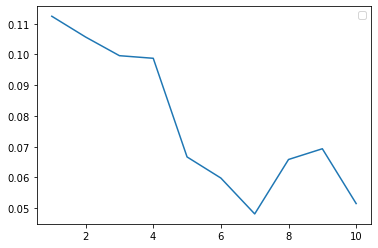

In [268]:
# 学習 SGD, He, ReLU
model = ScratchDeepNeuralNetworkClassifier(epoch=10, optimizer=SGD, initializer=HeInitializer, activator=ReLU)
model.fit(x_train, y_train_one_hot)
result(model, x_train, y_train)

[0.08052810177208736,
 0.049065083217074645,
 0.03105315934007326,
 0.022794020327213445,
 0.013782085458375747,
 0.01078128096504767,
 0.007256497275078254,
 0.005284172999552895,
 0.003904475965036524,
 0.0026652833763133083]

'pred: '

array([7, 4, 5, ..., 7, 1, 4])

0.999875

No handles with labels found to put in legend.


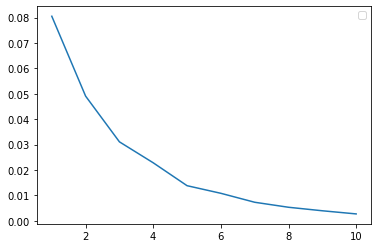

In [269]:
# 学習 AdaGrad, He, ReLU
model = ScratchDeepNeuralNetworkClassifier(epoch=10, optimizer=AdaGrad, initializer=HeInitializer, activator=ReLU)
model.fit(x_train, y_train_one_hot)
result(model, x_train, y_train)

[0.10418397123584588,
 0.06903913588319341,
 0.04370879778681212,
 0.036993572595839824,
 0.021907102793180522,
 0.017520111075481768,
 0.01277198254824133,
 0.009933751011874626,
 0.008232179978661274,
 0.006176137212764554]

'pred: '

array([7, 4, 5, ..., 7, 1, 4])

0.9995416666666667

No handles with labels found to put in legend.


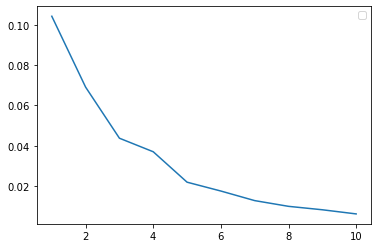

In [270]:
# 学習 AdaGrad, Xavier, Tanh
model = ScratchDeepNeuralNetworkClassifier(epoch=10, optimizer=AdaGrad, initializer=XavierInitializer, activator=Tanh)
model.fit(x_train, y_train_one_hot)
result(model, x_train, y_train)

[0.08429400445748486,
 0.05590653001073962,
 0.03297339613313664,
 0.02742390027628736,
 0.017218458764540104,
 0.013256084361410115,
 0.00881568809388363,
 0.006502697513738592,
 0.004809394818677885,
 0.0034626026677099042]

'pred: '

array([7, 4, 5, ..., 7, 1, 4])

0.9998125

No handles with labels found to put in legend.


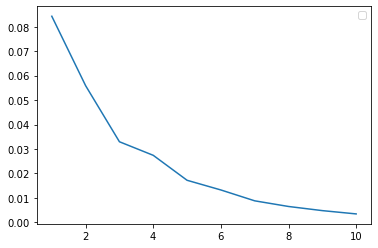

In [272]:
# 学習 AdaGrad, Xavier, ReLU
model = ScratchDeepNeuralNetworkClassifier(epoch=10, optimizer=AdaGrad, initializer=XavierInitializer, activator=ReLU)
model.fit(x_train, y_train_one_hot)
result(model, x_train, y_train)
